In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-dataset-cv/README.dataset.txt
/kaggle/input/brain-tumor-dataset-cv/README.roboflow.txt
/kaggle/input/brain-tumor-dataset-cv/data.yaml
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_1_slice_48_jpg.rf.44235e70bacd356d0fc58ed80e8e54df.txt
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_330_slice_44_jpg.rf.d5a21bf21e9e9177fc06538155433376.txt
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_254_slice_98_jpg.rf.4343d3b6f6b5a56c514a958baa16418e.txt
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_279_slice_97_jpg.rf.aa9be3c86d7edd917d45f3ad401bf189.txt
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_107_slice_71_jpg.rf.137678c0996eb7150ec8936f46f48022.txt
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_87_slice_91_jpg.rf.b49be97e770f39367dcd03cd429fd9c9.txt
/kaggle/input/brain-tumor-dataset-cv/valid/labels/volume_173_slice_96_jpg.rf.4861e431bc54f466148cbf196acb036e.txt
/kaggle/input/brain-tumor-dataset-cv/valid/la

In [5]:
#Import the libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import random
import os

In [6]:
#CLAHE Enhancement Technique
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


class CLAHEEnhancement:
    
    def __init__(self, image_path):
        self.image_path = image_path
        self.original_image = None
        self.enhanced_image = None
        logger.info(f"Initialized CLAHEEnhancement for: {image_path}")
    
    def load_image(self):
        try:
            self.original_image = cv2.imread(self.image_path)
            if self.original_image is None:
                raise ValueError("Failed to load image. Check file path.")
            logger.info(f"Image loaded successfully. Shape: {self.original_image.shape}")
            return True
        except Exception as e:
            logger.error(f"Error loading image: {str(e)}")
            return False
    
    def apply_clahe(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        logger.info("Applying CLAHE for contrast enhancement...")
        try:
            lab = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            l_clahe = clahe.apply(l)
            lab_clahe = cv2.merge([l_clahe, a, b])
            self.enhanced_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
            logger.info("CLAHE applied successfully")
            return self.enhanced_image
        except Exception as e:
            logger.error(f"Error applying CLAHE: {str(e)}")
            return None
    
    def visualize(self):
        if self.original_image is not None and self.enhanced_image is not None:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle('CLAHE Enhancement', fontsize=16, fontweight='bold')
            axes[0].imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(cv2.cvtColor(self.enhanced_image, cv2.COLOR_BGR2RGB))
            axes[1].set_title('CLAHE Enhanced')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
    
    def run(self):
        if self.load_image():
            self.apply_clahe()
            self.visualize()
            return self.enhanced_image
        return None




In [7]:
#GrabCut Segmentation
class GrabCutSegmentation:
    
    def __init__(self, image_path):
        self.image_path = image_path
        self.original_image = None
        self.segmented_image = None
        self.mask = None
        logger.info(f"Initialized GrabCutSegmentation for: {image_path}")
    
    def load_image(self):
        try:
            self.original_image = cv2.imread(self.image_path)
            if self.original_image is None:
                raise ValueError("Failed to load image. Check file path.")
            logger.info(f"Image loaded successfully. Shape: {self.original_image.shape}")
            return True
        except Exception as e:
            logger.error(f"Error loading image: {str(e)}")
            return False
    
    def apply_grabcut(self, iterations=5):
        logger.info("Applying GrabCut segmentation...")
        try:
            img = self.original_image
            h, w = img.shape[:2]
            margin_h, margin_w = int(h * 0.15), int(w * 0.15)
            rect = (margin_w, margin_h, w - 2*margin_w, h - 2*margin_h)
            mask = np.zeros(img.shape[:2], np.uint8)
            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)
            cv2.grabCut(img, mask, rect, bgd_model, fgd_model, iterations, cv2.GC_INIT_WITH_RECT)
            self.mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
            self.segmented_image = img * self.mask[:, :, np.newaxis]
            logger.info("GrabCut segmentation completed")
            return self.segmented_image, self.mask
        except Exception as e:
            logger.error(f"Error applying GrabCut: {str(e)}")
            return None, None
    
    def visualize(self):
        if self.original_image is not None and self.segmented_image is not None:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle('GrabCut Segmentation', fontsize=16, fontweight='bold')
            axes[0].imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(self.mask, cmap='gray')
            axes[1].set_title('Segmentation Mask')
            axes[1].axis('off')
            axes[2].imshow(cv2.cvtColor(self.segmented_image, cv2.COLOR_BGR2RGB))
            axes[2].set_title('Segmented Region')
            axes[2].axis('off')
            plt.tight_layout()
            plt.show()
    
    def run(self):
        if self.load_image():
            self.apply_grabcut()
            self.visualize()
            return self.segmented_image, self.mask
        return None, None


In [8]:
#Canny Edge Detection
class CannyEdgeDetection:
    
    def __init__(self, image_path):
        self.image_path = image_path
        self.original_image = None
        self.edges = None
        logger.info(f"Initialized CannyEdgeDetection for: {image_path}")
    
    def load_image(self):
        try:
            self.original_image = cv2.imread(self.image_path)
            if self.original_image is None:
                raise ValueError("Failed to load image. Check file path.")
            logger.info(f"Image loaded successfully. Shape: {self.original_image.shape}")
            return True
        except Exception as e:
            logger.error(f"Error loading image: {str(e)}")
            return False
    
    def apply_canny_edge_detection(self, threshold1=50, threshold2=150):
        logger.info("Applying Canny edge detection...")
        try:
            img = self.original_image
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            self.edges = cv2.Canny(blurred, threshold1, threshold2)
            logger.info("Canny edge detection completed")
            return self.edges
        except Exception as e:
            logger.error(f"Error applying Canny: {str(e)}")
            return None
    
    def visualize(self):
        if self.original_image is not None and self.edges is not None:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle('Canny Edge Detection', fontsize=16, fontweight='bold')
            axes[0].imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(self.edges, cmap='gray')
            axes[1].set_title('Detected Edges')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
    
    def run(self):
        if self.load_image():
            self.apply_canny_edge_detection()
            self.visualize()
            return self.edges
        return None

2025-11-24 21:27:57,608 - INFO - Initialized CLAHEEnhancement for: /kaggle/input/brain-tumor-dataset-cv/train/images/volume_64_slice_116_jpg.rf.2376355bda691b12de025c101a588e14.jpg
2025-11-24 21:27:57,612 - INFO - Image loaded successfully. Shape: (240, 240, 3)
2025-11-24 21:27:57,613 - INFO - Applying CLAHE for contrast enhancement...
2025-11-24 21:27:57,616 - INFO - CLAHE applied successfully



Selected: train/volume_64_slice_116_jpg.rf.2376355bda691b12de025c101a588e14.jpg

TECHNIQUE 1: CLAHE Enhancement


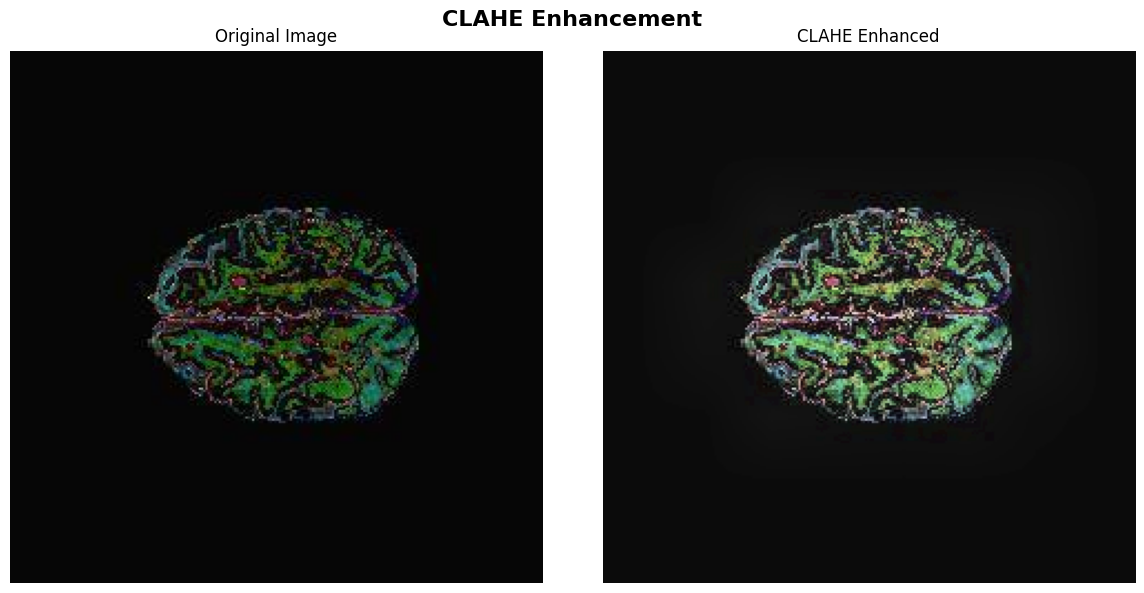

2025-11-24 21:27:57,875 - INFO - Initialized GrabCutSegmentation for: /kaggle/input/brain-tumor-dataset-cv/train/images/volume_64_slice_116_jpg.rf.2376355bda691b12de025c101a588e14.jpg
2025-11-24 21:27:57,878 - INFO - Image loaded successfully. Shape: (240, 240, 3)
2025-11-24 21:27:57,878 - INFO - Applying GrabCut segmentation...
2025-11-24 21:27:58,031 - INFO - GrabCut segmentation completed



TECHNIQUE 2: GrabCut Segmentation


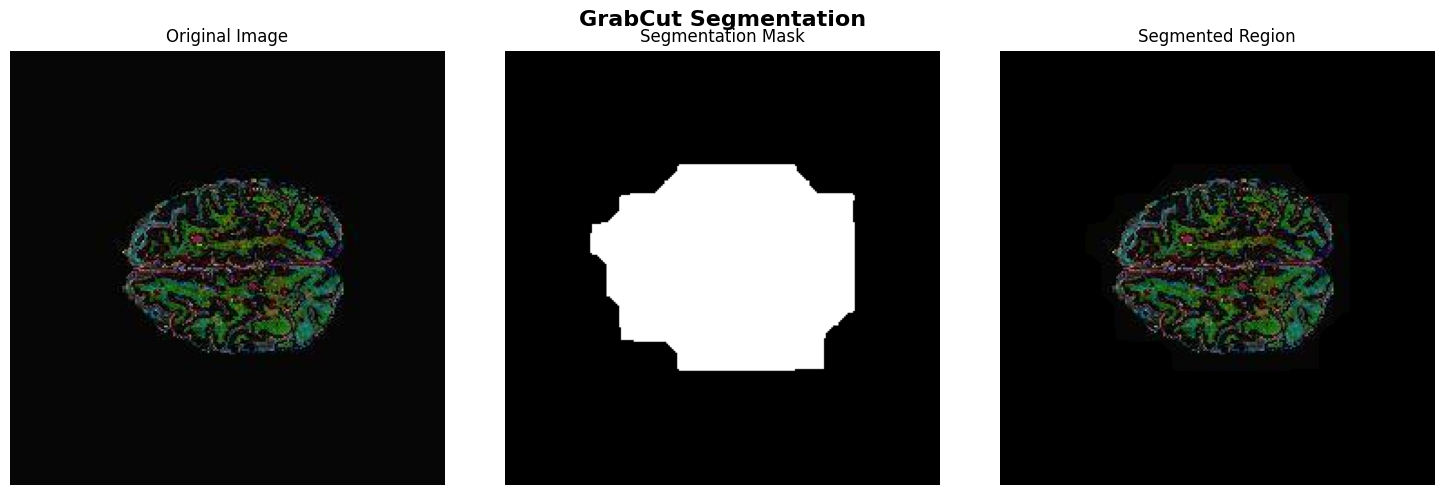

2025-11-24 21:27:58,327 - INFO - Initialized CannyEdgeDetection for: /kaggle/input/brain-tumor-dataset-cv/train/images/volume_64_slice_116_jpg.rf.2376355bda691b12de025c101a588e14.jpg
2025-11-24 21:27:58,330 - INFO - Image loaded successfully. Shape: (240, 240, 3)
2025-11-24 21:27:58,330 - INFO - Applying Canny edge detection...
2025-11-24 21:27:58,332 - INFO - Canny edge detection completed



TECHNIQUE 3: Canny Edge Detection


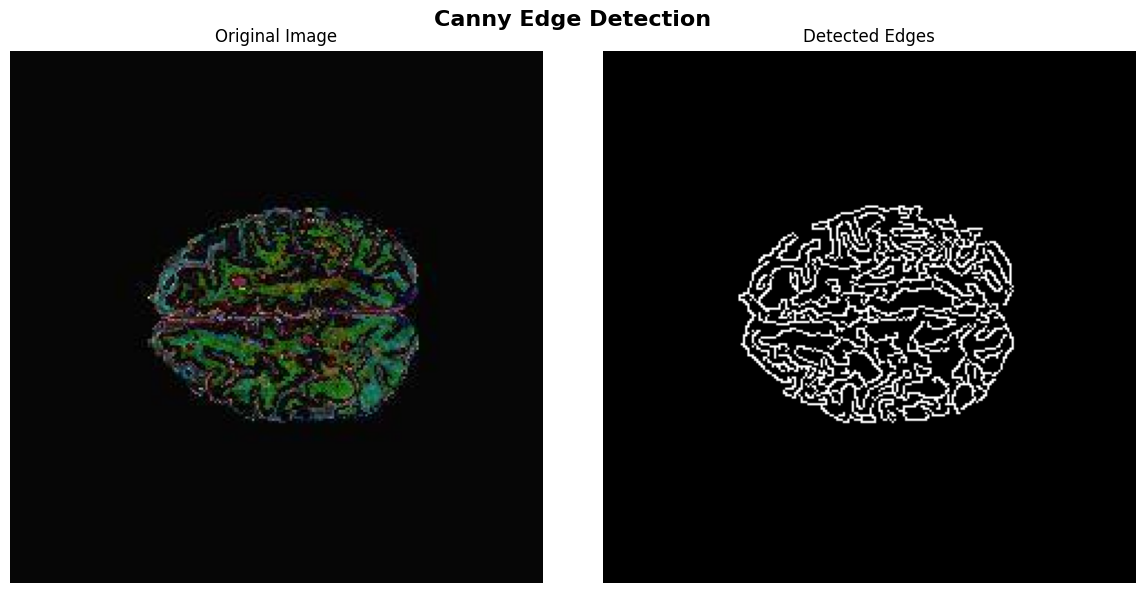


All techniques executed successfully!


In [9]:
#Visualization
def main():
    # dataset path
    dataset_path = "/kaggle/input/brain-tumor-dataset-cv"
    
    
    splits = ['train', 'test', 'valid']
    random_split = random.choice(splits)
    
    
    images_folder = os.path.join(dataset_path, random_split, 'images')
    image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Selecting a random image
    random_image = random.choice(image_files)
    image_path = os.path.join(images_folder, random_image)
    
    print(f"\n{'='*60}")
    print(f"Selected: {random_split}/{random_image}")
    print(f"{'='*60}")
    
    print("\nTECHNIQUE 1: CLAHE Enhancement")
    print("="*50)
    clahe = CLAHEEnhancement(image_path)
    enhanced_img = clahe.run()
    
    print("\nTECHNIQUE 2: GrabCut Segmentation")
    print("="*50)
    grabcut = GrabCutSegmentation(image_path)
    segmented_img, mask = grabcut.run()
    
    print("\nTECHNIQUE 3: Canny Edge Detection")
    print("="*50)
    canny = CannyEdgeDetection(image_path)
    edges = canny.run()
    
    print("\nAll techniques executed successfully!")

if __name__ == "__main__":
    main()